# ML Detect DDos Attack

- Author: Benazir de la Rosa
- Contact: benazir.delarosa@gmail.com

In [103]:
import pandas as pd
import shap
import datetime
import seaborn
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import confusion_matrix
from sklearn import metrics

## Read Data

In [2]:
fridge_df = pd.read_csv("C:\\Users\\g1238\\Documents\\tcs_hackaton\\data\\ML_app_data\\Train_Test_IoT_Fridge.csv")
garage_door_df = pd.read_csv("C:\\Users\\g1238\\Documents\\tcs_hackaton\\data\\ML_app_data\\Train_Test_IoT_Garage_Door.csv")
gps_tracker_df = pd.read_csv("C:\\Users\\g1238\\Documents\\tcs_hackaton\\data\\ML_app_data\\Train_Test_IoT_GPS_Tracker.csv")
modbus_df = pd.read_csv("C:\\Users\\g1238\\Documents\\tcs_hackaton\\data\\ML_app_data\\Train_Test_IoT_Modbus.csv")
motion_light_df = pd.read_csv("C:\\Users\\g1238\\Documents\\tcs_hackaton\\data\\ML_app_data\\Train_Test_IoT_Motion_Light.csv")
thermostate_df = pd.read_csv("C:\\Users\\g1238\\Documents\\tcs_hackaton\\data\\ML_app_data\\Train_Test_IoT_Thermostat.csv")
weather_df = pd.read_csv("C:\\Users\\g1238\\Documents\\tcs_hackaton\\data\\ML_app_data\\Train_Test_IoT_Weather.csv")

### Fridge Data

In [3]:
fridge_df = fridge_df[fridge_df['type'].isin(['ddos','normal'])]
fridge_df['date'] = fridge_df['ts'].apply(lambda x:datetime.datetime.utcfromtimestamp(x))
fridge_df['ts_lag'] = fridge_df['ts'].shift(1)
fridge_df['temp_lag'] = fridge_df['fridge_temperature'].shift(1)
fridge_df['temp_delta_fridge'] = fridge_df['fridge_temperature'] - fridge_df['temp_lag']
fridge_df['ts_delta_fridge'] = fridge_df['ts'] - fridge_df['ts_lag']
#fridge_df = fridge_df.drop(columns=['ts','date','time'])
fridge_df['month'] = fridge_df['date'].apply(lambda x:x.month)
fridge_df['day'] = fridge_df['date'].apply(lambda x:x.day)
fridge_df['hour'] = fridge_df['date'].apply(lambda x:x.hour)
fridge_df['minute'] = fridge_df['date'].apply(lambda x:x.minute)
fridge_df['second'] = fridge_df['date'].apply(lambda x:x.second)
fridge_df['temp_condition'] = fridge_df['temp_condition'].apply(lambda x:x.replace(' ',''))

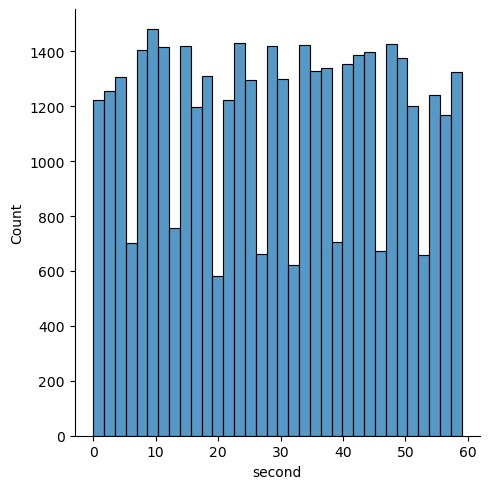

In [4]:
seaborn.displot(fridge_df, x="second")

<Axes: xlabel='temp_condition', ylabel='count'>

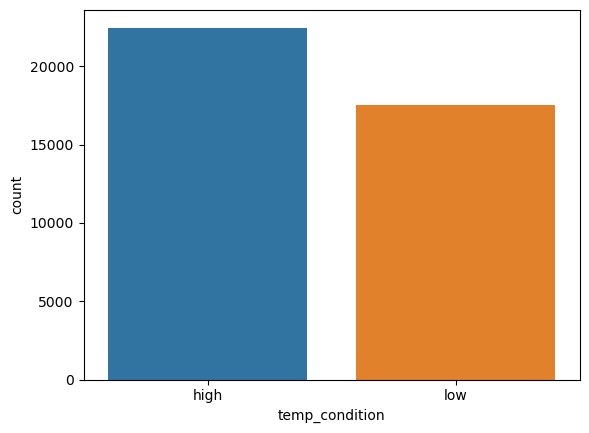

In [5]:
seaborn.countplot(x='temp_condition', data=fridge_df)

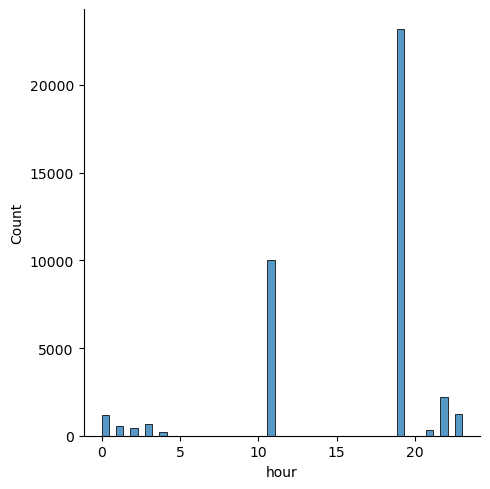

In [6]:
seaborn.displot(fridge_df, x="hour")

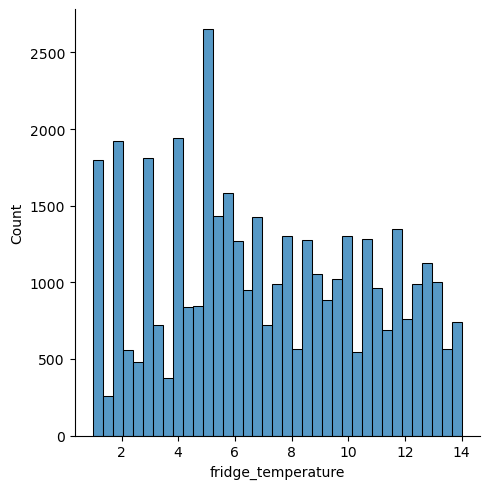

In [7]:
seaborn.displot(fridge_df, x="fridge_temperature")

In [8]:
fridge_df = fridge_df.drop(columns=['time','type','date','ts_lag'])
fridge_df_dummies = pd.get_dummies(fridge_df['temp_condition'])

In [9]:
fridge_df = fridge_df.drop(columns=['temp_condition','ts','temp_lag'])

In [10]:
fridge_df = fridge_df.join(fridge_df_dummies)

In [11]:
fridge_df = fridge_df[['month','day','hour','minute','second','fridge_temperature','temp_delta_fridge','ts_delta_fridge','high','low','label']]

In [12]:
fridge_df

,month,day,hour,minute,second,fridge_temperature,temp_delta_fridge,ts_delta_fridge,high,low,label
0,4,26,2,19,40,9.00,NaN,NaN,1,0,1
1,4,26,2,19,40,9.25,0.25,0.0,1,0,1
2,4,26,2,19,45,12.65,3.40,5.0,1,0,1
3,4,26,2,19,45,4.65,-8.00,0.0,0,1,1
4,4,26,2,19,55,12.65,8.00,10.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
59939,4,2,11,7,15,7.65,-2.20,0.0,1,0,0
59940,4,2,11,7,15,13.85,6.20,0.0,1,0,0
59941,4,2,11,7,15,5.40,-8.45,0.0,0,1,0
59942,4,2,11,7,15,2.90,-2.50,0.0,0,1,0


### Garage Door Data

In [13]:
garage_door_df = garage_door_df[garage_door_df['type'].isin(['ddos','normal'])]

In [14]:
garage_door_df['date'] = garage_door_df['ts'].apply(lambda x:datetime.datetime.utcfromtimestamp(x))
garage_door_df['month'] = garage_door_df['date'].apply(lambda x:x.month)
garage_door_df['day'] = garage_door_df['date'].apply(lambda x:x.day)
garage_door_df['hour'] = garage_door_df['date'].apply(lambda x:int(x.hour))
garage_door_df['minute'] = garage_door_df['date'].apply(lambda x:x.minute)
garage_door_df['second'] = garage_door_df['date'].apply(lambda x:x.second)
garage_door_df['ts_lag'] = garage_door_df['ts'].shift(1)
garage_door_df['ts_delta_door'] = garage_door_df['ts'] - garage_door_df['ts_lag']
garage_door_df['sphone_signal'] = garage_door_df['sphone_signal'].apply(lambda x:str(x).replace('true',str(1)))
garage_door_df['sphone_signal'] = garage_door_df['sphone_signal'].apply(lambda x:str(x).replace('false',str(0)))
garage_door_df['sphone_signal'] = [int(x) for x in garage_door_df['sphone_signal']]


In [15]:
garage_door_df = garage_door_df.drop(columns=['time','type'])

In [16]:
garage_door_df.dtypes

ts                        int64
date             datetime64[ns]
door_state               object
sphone_signal             int64
label                     int64
month                     int64
day                       int64
hour                      int64
minute                    int64
second                    int64
ts_lag                  float64
ts_delta_door           float64
dtype: object

In [17]:
garage_door_df['door_state'].unique()

array(['closed', 'open'], dtype=object)

In [18]:
close_door = garage_door_df[garage_door_df['door_state'] == 'closed']


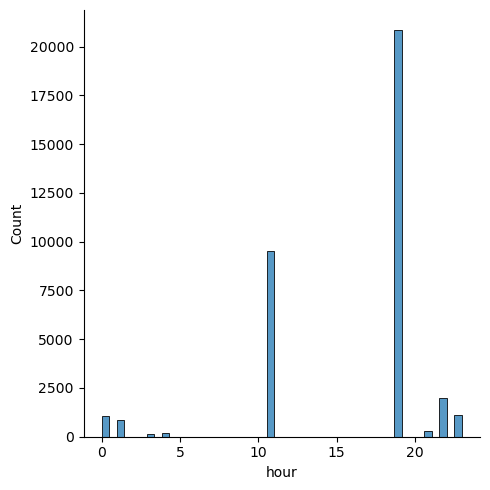

In [19]:

graph = seaborn.displot(close_door, x="hour")


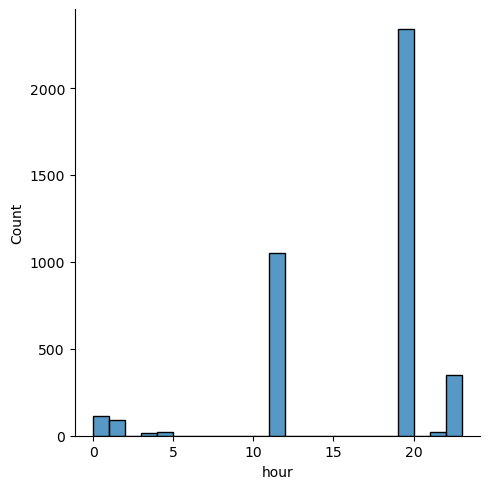

In [20]:
graph = seaborn.displot(garage_door_df[garage_door_df['door_state'] == "open"], x="hour")


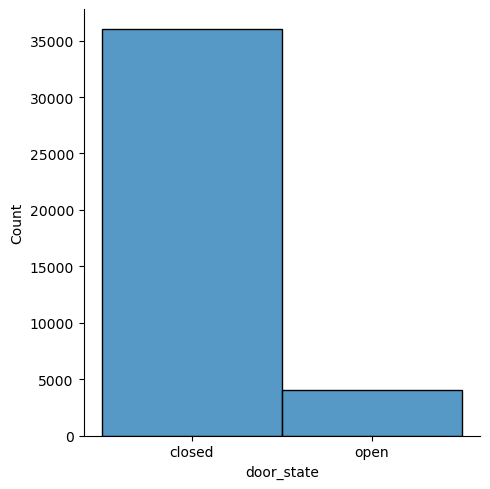

In [21]:
seaborn.displot(garage_door_df, x="door_state")

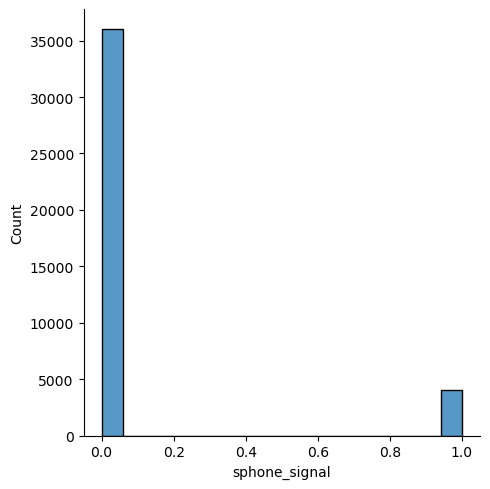

In [22]:
seaborn.displot(garage_door_df, x="sphone_signal")

In [23]:
def encode_door_state(string):
    label = 0
    if string == 'closed':
        label = 0
    elif string == 'open':
        label = 1
    return label
garage_door_df['door_state'] = list(map(encode_door_state,garage_door_df['door_state']))


In [24]:
garage_door_df = garage_door_df.drop(columns=['date','ts','ts_lag'])
garage_door_df = garage_door_df[['month','day','hour','minute','second','door_state','sphone_signal','ts_delta_door','ts_delta_door','label']]

In [25]:
garage_door_df

,month,day,hour,minute,second,door_state,sphone_signal,ts_delta_door,ts_delta_door,label
0,4,25,21,42,33,0,0,NaN,NaN,1
1,4,25,21,42,38,0,0,5.0,5.0,1
2,4,25,21,42,43,0,0,5.0,5.0,1
3,4,25,21,42,48,0,0,5.0,5.0,1
4,4,25,21,42,58,0,0,10.0,10.0,1
...,...,...,...,...,...,...,...,...,...,...
59582,4,2,11,9,17,0,0,0.0,0.0,0
59583,4,2,11,9,17,1,1,0.0,0.0,0
59584,4,2,11,9,17,0,0,0.0,0.0,0
59585,4,2,11,9,17,0,0,0.0,0.0,0


### GPS Tracker Data

In [26]:
gps_tracker_df = gps_tracker_df[gps_tracker_df['type'].isin(['ddos','normal'])]
gps_tracker_df['ts_lag'] = gps_tracker_df['ts'].shift(1)
gps_tracker_df['ts_delta_gps'] = gps_tracker_df['ts'] - gps_tracker_df['ts_lag']
gps_tracker_df['latitude_lag'] = gps_tracker_df['latitude'].shift(1)
gps_tracker_df['longitude_lag'] = gps_tracker_df['longitude'].shift(1)
gps_tracker_df['latitude_delta'] = gps_tracker_df['latitude'] - gps_tracker_df['latitude_lag']
gps_tracker_df['longitude_delta'] = gps_tracker_df['longitude'] - gps_tracker_df['longitude_lag']
gps_tracker_df['date'] = gps_tracker_df['ts'].apply(lambda x:datetime.datetime.utcfromtimestamp(x))
gps_tracker_df['month'] = gps_tracker_df['date'].apply(lambda x:x.month)
gps_tracker_df['day'] = gps_tracker_df['date']. apply(lambda x:x.day)
gps_tracker_df['hour'] = gps_tracker_df['date'].apply(lambda x:x.hour)
gps_tracker_df['minute'] = gps_tracker_df['date'].apply(lambda x:x.minute)
gps_tracker_df['second'] = gps_tracker_df['date'].apply(lambda x:x.second)


In [27]:
lat_grp = gps_tracker_df.groupby('type')['latitude'].agg('mean').reset_index()

In [28]:
lon_grp = gps_tracker_df.groupby('type')['longitude'].agg('mean').reset_index()

In [29]:
gps_overview = lat_grp.merge(lon_grp, on=['type'], how='left')
gps_overview

,type,latitude,longitude
0,ddos,136.312022,148.993691
1,normal,24.835689,34.714192


In [30]:
gps_tracker_df = gps_tracker_df.drop(columns=['time','type','date','ts_lag','ts','longitude_lag','latitude_lag'])
gps_tracker_df = gps_tracker_df[['month','day','hour','minute','second','latitude','longitude','ts_delta_gps','latitude_delta','longitude_delta','label']]
gps_tracker_df

,month,day,hour,minute,second,latitude,longitude,ts_delta_gps,latitude_delta,longitude_delta,label
0,4,26,1,31,39,116.521704,132.162504,NaN,NaN,NaN,1
1,4,26,1,31,41,121.742933,135.072500,2.0,5.221228,2.909996,1
2,4,26,1,31,46,121.795929,135.110198,5.0,0.052996,0.037698,1
3,4,26,1,31,49,116.611216,132.224555,3.0,-5.184713,-2.885643,1
4,4,26,1,31,51,121.841526,135.151362,2.0,5.230310,2.926807,1
...,...,...,...,...,...,...,...,...,...,...,...
58955,4,2,11,2,8,1.028628,10.810522,0.0,0.339129,-0.029551,0
58956,4,2,11,2,8,0.345361,10.727989,0.0,-0.683266,-0.082533,0
58957,4,2,11,2,8,0.423384,10.508036,0.0,0.078023,-0.219953,0
58958,4,2,11,2,8,0.445292,10.381356,0.0,0.021907,-0.126680,0


# Modbus Data

In [31]:
#leave out signal because there is no data when it is in ddos attack
modbus_df['type'].unique()

array(['injection', 'backdoor', 'normal', 'password', 'scanning', 'xss'],
      dtype=object)

### Motion Lights Data

In [32]:
motion_light_df = motion_light_df[motion_light_df['type'].isin(['ddos','normal'])]
motion_light_df['date'] = motion_light_df['ts'].apply(lambda x:datetime.datetime.utcfromtimestamp(x))
motion_light_df['ts_lag'] = motion_light_df['ts'].shift(1)
motion_light_df['ts_delta_motion_light'] = motion_light_df['ts'] - motion_light_df['ts_lag']
motion_light_df['month'] = motion_light_df['date'].apply(lambda x:x.month)
motion_light_df['day'] = motion_light_df['date'].apply(lambda x:x.day)
motion_light_df['hour'] = motion_light_df['date'].apply(lambda x:x.hour)
motion_light_df['minute'] = motion_light_df['date'].apply(lambda x:x.minute)
motion_light_df['second'] = motion_light_df['date'].apply(lambda x:x.second)

In [33]:
hours_inspection_df = motion_light_df.groupby('hour')['motion_status'].agg('sum').reset_index()
hours_inspection_df_ddos = motion_light_df[motion_light_df['type'] == 'ddos'].groupby('hour')['motion_status'].agg('sum').reset_index()
hours_inspection_df_normal = motion_light_df[motion_light_df['type'] == 'normal'].groupby('hour')['motion_status'].agg('sum').reset_index()

<Axes: xlabel='hour', ylabel='motion_status'>

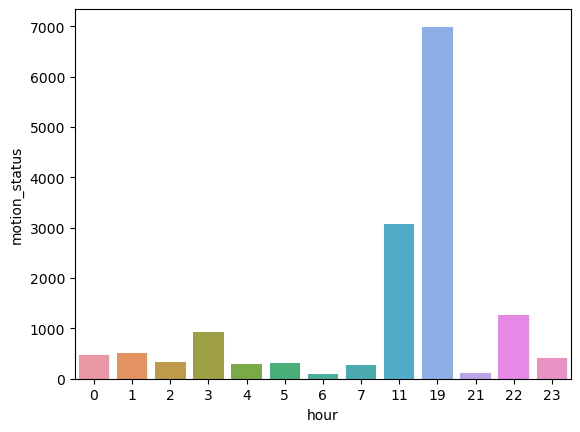

In [34]:
seaborn.barplot(data=hours_inspection_df, x="hour", y="motion_status")

<Axes: xlabel='hour', ylabel='motion_status'>

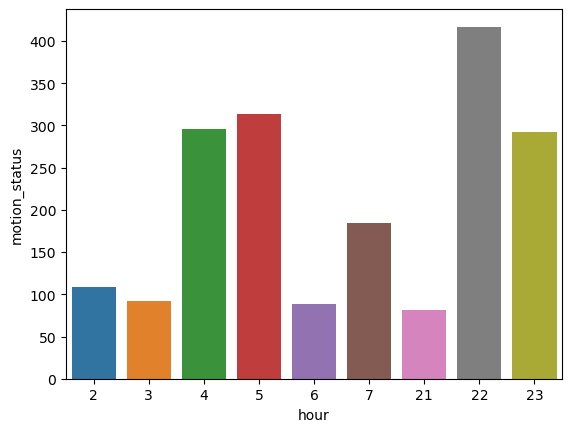

In [35]:
seaborn.barplot(data=hours_inspection_df_ddos, x="hour", y="motion_status")

<Axes: xlabel='hour', ylabel='motion_status'>

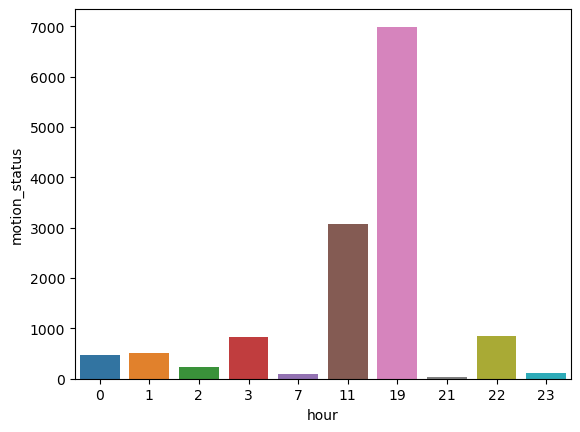

In [36]:
seaborn.barplot(data=hours_inspection_df_normal, x="hour", y="motion_status")

In [37]:
def encode_light_status(string):
    label = 0
    if string == 'on':
        label = 1
    elif string == 'off':
        label = 0
    return label

motion_light_df['light_status'] = list(map(encode_light_status,motion_light_df['light_status']))
motion_light_df = motion_light_df.drop(columns=['date','time','type','ts_lag','ts'])


In [38]:
motion_light_df = motion_light_df[['month','day','hour','minute','second','ts_delta_motion_light','motion_status','light_status','label']]

In [39]:
motion_light_df

,month,day,hour,minute,second,ts_delta_motion_light,motion_status,light_status,label
0,4,26,2,41,37,NaN,0,0,1
1,4,26,2,41,42,5.0,1,0,1
2,4,26,2,41,43,1.0,0,0,1
3,4,26,2,41,48,5.0,1,0,1
4,4,26,2,41,48,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...
59483,4,1,23,7,53,4.0,0,0,0
59484,4,1,23,7,53,0.0,1,0,0
59485,4,1,23,7,54,1.0,0,0,0
59486,4,1,23,7,55,1.0,0,0,0


### Thermostate Data

In [40]:
#we have to leave out thermostate because it does not have data under ddos attack.
thermostate_df['type'].unique()

array(['injection', 'backdoor', 'normal', 'password', 'ransomware',
       'scanning', 'xss'], dtype=object)

### Weather data

In [41]:
weather_df = weather_df[weather_df['type'].isin(['ddos','normal'])]
weather_df['date'] = weather_df['ts'].apply(lambda x:datetime.datetime.utcfromtimestamp(x))
weather_df['month'] = weather_df['date'].apply(lambda x:x.month)
weather_df['day'] = weather_df['date'].apply(lambda x:x.day)
weather_df['hour'] = weather_df['date'].apply(lambda x:x.hour)
weather_df['minute'] = weather_df['date'].apply(lambda x:x.minute)
weather_df['second'] = weather_df['date'].apply(lambda x:x.second)
weather_df['ts_lag'] = weather_df['ts'].shift(1)
weather_df['ts_delta_weather'] = weather_df['ts'] - weather_df['ts_lag'] 
weather_df['temperature_lag'] = weather_df['temperature'].shift(1)
weather_df['temperature_delta'] = weather_df['temperature'] - weather_df['temperature_lag']
weather_df['pressure_lag'] = weather_df['pressure'].shift(1)
weather_df['pressure_delta'] = weather_df['pressure'] - weather_df['pressure_lag']
weather_df['humidity_lag'] = weather_df['humidity'].shift(1)
weather_df['humidity_delta'] = weather_df['humidity'] - weather_df['humidity_lag']


In [42]:
weather_df_hours_ddos = weather_df[weather_df['type']=='ddos'].groupby('hour')['temperature'].agg('mean').reset_index()

In [43]:
weather_df_hours_ddos

,hour,temperature
0,0,41.675220
1,5,35.009764
2,21,41.480547
3,22,40.782752
4,23,39.064633


In [44]:
weather_df_hours_all_temp = weather_df.groupby('hour')['temperature'].agg('mean').reset_index()
weather_df_hours_all_press = weather_df.groupby('hour')['pressure'].agg('mean').reset_index()
weather_df_hours_all_hum = weather_df.groupby('hour')['humidity'].agg('mean').reset_index()

In [45]:
weather_df_hours_all = weather_df_hours_all_temp.merge(weather_df_hours_all_press, on=['hour'], how='left')

In [46]:
weather_df_hours_all = weather_df_hours_all.merge(weather_df_hours_all_hum, on='hour', how='left')

In [47]:
weather_df_hours_all

,hour,temperature,pressure,humidity
0,0,37.807178,0.510013,62.265056
1,2,33.940848,1.979854,52.265013
2,3,35.611031,2.413432,40.971378
3,4,35.858769,2.887207,42.038269
4,5,35.009764,-2.731527,46.428088
5,19,35.269330,1.013980,49.914594
6,21,40.283753,0.939209,55.452396
7,22,38.065876,0.697871,45.428554
8,23,36.220592,0.353940,55.610632


In [48]:
weather_df_hours_all_unpivot = pd.melt(weather_df_hours_all, id_vars='hour', value_vars=['temperature','pressure','humidity'])

In [49]:
weather_df_hours_all_unpivot.columns = ['hour','environment condition','measure']

<Axes: xlabel='hour', ylabel='measure'>

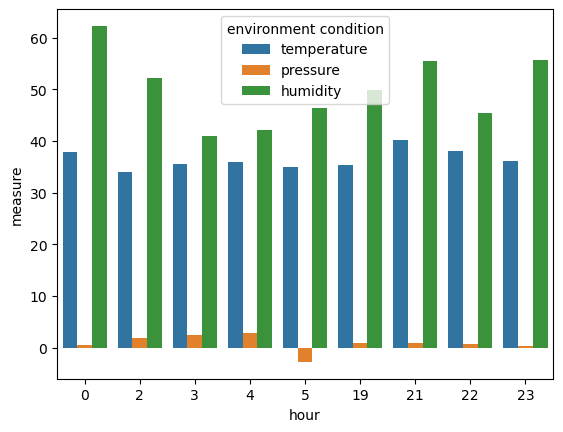

In [50]:
seaborn.barplot(x='hour',y='measure',hue='environment condition',data=weather_df_hours_all_unpivot)


In [51]:
weather_df = weather_df.drop(columns=['date','time','type','ts','ts_lag','temperature_lag','pressure_lag','humidity_lag'])

In [52]:
weather_df = weather_df[['month','day','hour','minute','second','temperature','pressure','humidity','ts_delta_weather','temperature_delta','pressure_delta','humidity_delta','label']]

# Feature Engineering Final Dataset

In [53]:
fridge_df_cp = fridge_df.copy()
garage_door_df_cp = garage_door_df.copy()
motion_light_df_cp = motion_light_df.copy()
gps_tracker_df_cp = gps_tracker_df.copy()
weather_df_cp = weather_df.copy()

In [54]:
ml_df = fridge_df_cp.merge(garage_door_df_cp, on=['month','day','hour','minute','second','label'], how='left')

In [55]:
motion_light_df_test = motion_light_df_cp

In [56]:
motion_light_df_test['rank'] = motion_light_df_test.groupby(['month','day','hour','minute','second'])['label'].rank('max')

In [57]:
motion_light_df_cp = motion_light_df_test[motion_light_df_test['rank'] == 1.0].drop(columns=['rank'])

In [58]:
ml_df = ml_df.merge(motion_light_df_cp, on=['month','day','hour','minute','second','label'], how='left')


In [59]:
ml_df = ml_df.drop_duplicates()

In [60]:
gps_tracker_df_cp['rank'] = gps_tracker_df_cp.groupby(['month','day','hour','minute','second'])['label'].rank('max')

In [61]:
gps_tracker_df_cp = gps_tracker_df_cp[gps_tracker_df_cp['rank'] == 1.0].drop(columns=['rank'])

In [62]:
ml_df = ml_df.merge(gps_tracker_df_cp, on=['month','day', 'hour','minute','second','label'], how='left')

In [63]:
weather_df_cp['rank'] = weather_df_cp.groupby(['month','day','hour','minute','second'])['label'].rank('max')

In [64]:
weather_df_cp = weather_df_cp[weather_df_cp['rank'] == 1].drop(columns=['rank'])

In [65]:
ml_df = ml_df.merge(weather_df_cp, on=['month','day', 'hour','minute','second','label'], how='left')

In [66]:
ml_df = ml_df.fillna(method='bfill')
ml_df = ml_df.fillna(method='ffill').drop_duplicates()

In [67]:
ml_df = ml_df[['month', 'day', 'hour', 'minute', 'second', 'fridge_temperature',
       'temp_delta_fridge', 'ts_delta_fridge', 'high', 'low',
       'door_state', 'sphone_signal', 'ts_delta_door', 'ts_delta_door',
       'ts_delta_motion_light', 'motion_status', 'light_status', 'latitude',
       'longitude', 'ts_delta_gps', 'latitude_delta', 'longitude_delta',
       'temperature', 'pressure', 'humidity', 'ts_delta_weather',
       'temperature_delta', 'pressure_delta', 'humidity_delta','label']]

In [68]:
ml_df = ml_df.drop(columns=['month','day','hour','minute','second'])

<Axes: >

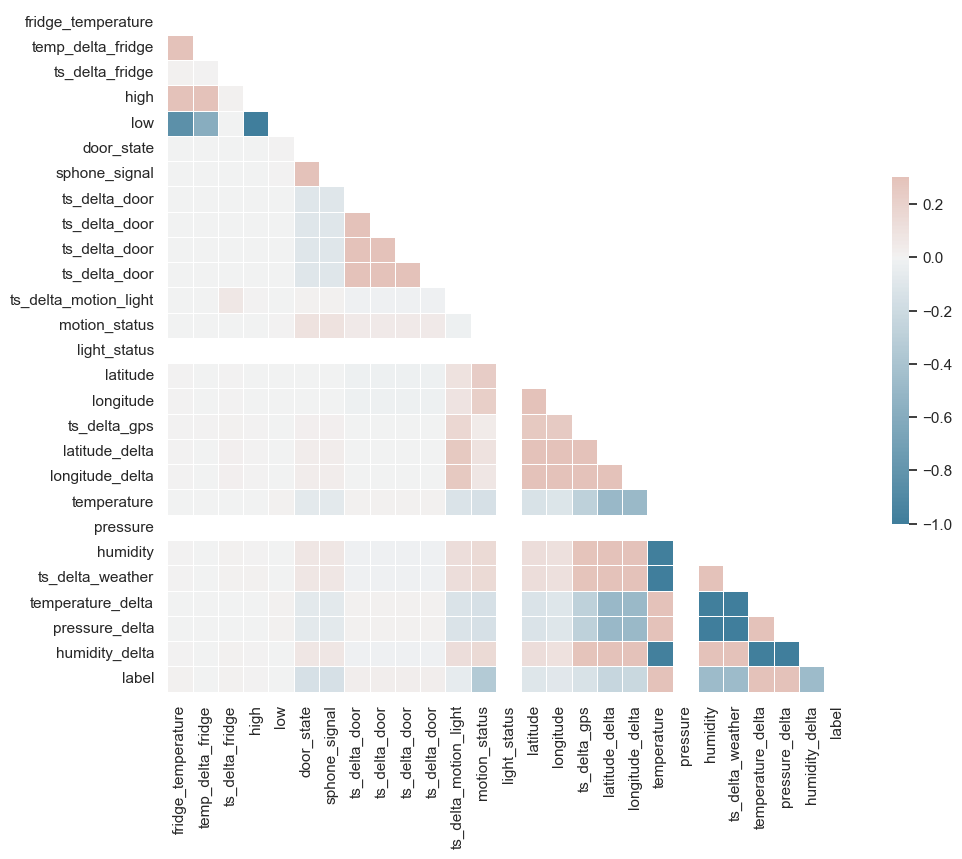

In [69]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

corr = ml_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Train XGboost Model

In [70]:
ml_df = ml_df.drop(columns=['fridge_temperature','temp_delta_fridge','door_state','ts_delta_door'])

In [71]:
ml_df

,ts_delta_fridge,high,low,sphone_signal,ts_delta_motion_light,motion_status,light_status,latitude,longitude,ts_delta_gps,latitude_delta,longitude_delta,temperature,pressure,humidity,ts_delta_weather,temperature_delta,pressure_delta,humidity_delta,label
0,0.0,1,0,0.0,7.0,0.0,0.0,141.751056,158.205450,3.0,-6.955145,-4.449747,31.788508,1.035,32.036579,-388.0,-8.961229,0.256257,-58.777596,1
1,0.0,1,0,0.0,7.0,0.0,0.0,141.751056,158.205450,3.0,-6.955145,-4.449747,31.788508,1.035,32.036579,-388.0,-8.961229,0.256257,-58.777596,1
2,5.0,1,0,0.0,7.0,0.0,0.0,141.751591,158.213973,3.0,-7.044205,-4.449182,31.788508,1.035,32.036579,-388.0,-8.961229,0.256257,-58.777596,1
3,0.0,0,1,0.0,7.0,0.0,0.0,141.751591,158.213973,3.0,-7.044205,-4.449182,31.788508,1.035,32.036579,-388.0,-8.961229,0.256257,-58.777596,1
4,10.0,1,0,0.0,7.0,0.0,0.0,141.802136,158.228847,3.0,-6.998426,-4.622972,31.788508,1.035,32.036579,-388.0,-8.961229,0.256257,-58.777596,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96181,0.0,0,1,0.0,1.0,1.0,0.0,52.268667,62.672201,3.0,-5.249999,-5.700814,24.017085,1.035,40.001059,1.0,-25.099495,0.000000,-38.948562,0
96182,0.0,0,1,1.0,1.0,1.0,0.0,52.268667,62.672201,3.0,-5.249999,-5.700814,24.017085,1.035,40.001059,1.0,-25.099495,0.000000,-38.948562,0
96183,0.0,1,0,0.0,1.0,1.0,0.0,52.268667,62.672201,3.0,-5.249999,-5.700814,24.017085,1.035,40.001059,1.0,-25.099495,0.000000,-38.948562,0
96184,0.0,1,0,0.0,1.0,1.0,0.0,52.268667,62.672201,3.0,-5.249999,-5.700814,24.017085,1.035,40.001059,1.0,-25.099495,0.000000,-38.948562,0


In [72]:
X = ml_df.iloc[:,:-1]
y = ml_df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)


# Hyperparameter Tunning

In [73]:
space={ 'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'max_leaves': hp.quniform("max_leaves", 3, 18, 1),
        'learning_rate' : hp.uniform('learning_rate', 0.5,1),
        'n_estimators': 10,
        'seed': 0
    }

In [74]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), 
                    learning_rate = space['learning_rate'], max_leaves= int(space['max_leaves']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [75]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                 
0.9827424888242021                                     
  1%|          | 1/100 [00:00<01:06,  1.49trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.982534567002807                                                                 
  2%|▏         | 2/100 [00:01<00:58,  1.68trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.9826905083688533                                                                
  3%|▎         | 3/100 [00:01<01:02,  1.55trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.9826385279135045                                                                
  4%|▍         | 4/100 [00:02<00:56,  1.69trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.9826905083688533                                                                
  5%|▌         | 5/100 [00:03<00:55,  1.70trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.9826905083688533                                                                
  6%|▌         | 6/100 [00:03<00:53,  1.75trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.9824825865474581                                                                
  7%|▋         | 7/100 [00:04<00:53,  1.73trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.9827424888242021                                                                
  8%|▊         | 8/100 [00:04<00:51,  1.77trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.9817028797172264                                                                
  9%|▉         | 9/100 [00:04<00:44,  2.04trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.9818068406279239                                                                
 10%|█         | 10/100 [00:05<00:39,  2.26trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.982274664726063                                                                  
 11%|█         | 11/100 [00:05<00:39,  2.26trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9825865474581558                                                                 
 12%|█▏        | 12/100 [00:06<00:39,  2.21trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9823266451814118                                                                 
 13%|█▎        | 13/100 [00:06<00:38,  2.29trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.981287036074436                                                                  
 14%|█▍        | 14/100 [00:06<00:34,  2.46trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9823786256367606                                                                 
 15%|█▌        | 15/100 [00:07<00:34,  2.44trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9823786256367606                                                                 
 16%|█▌        | 16/100 [00:07<00:34,  2.46trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 17%|█▋        | 17/100 [00:08<00:37,  2.22trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 18%|█▊        | 18/100 [00:08<00:37,  2.19trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826385279135045                                                                 
 19%|█▉        | 19/100 [00:09<00:38,  2.11trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.982274664726063                                                                  
 20%|██        | 20/100 [00:09<00:35,  2.24trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 21%|██        | 21/100 [00:10<00:39,  2.01trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 22%|██▏       | 22/100 [00:10<00:40,  1.93trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 23%|██▎       | 23/100 [00:11<00:41,  1.84trial/s, best loss: -0.9827424888242021]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827944692795509                                                                 
 24%|██▍       | 24/100 [00:12<00:40,  1.88trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 25%|██▌       | 25/100 [00:12<00:39,  1.89trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 26%|██▌       | 26/100 [00:13<00:39,  1.88trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 27%|██▋       | 27/100 [00:13<00:38,  1.92trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827944692795509                                                                 
 28%|██▊       | 28/100 [00:14<00:37,  1.93trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 29%|██▉       | 29/100 [00:14<00:37,  1.87trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 30%|███       | 30/100 [00:15<00:37,  1.89trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 31%|███       | 31/100 [00:15<00:35,  1.92trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826385279135045                                                                 
 32%|███▏      | 32/100 [00:16<00:37,  1.83trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 33%|███▎      | 33/100 [00:16<00:39,  1.71trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 34%|███▍      | 34/100 [00:17<00:38,  1.71trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 35%|███▌      | 35/100 [00:18<00:37,  1.73trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 36%|███▌      | 36/100 [00:18<00:36,  1.78trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9821707038153654                                                                 
 37%|███▋      | 37/100 [00:19<00:31,  1.97trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826385279135045                                                                 
 38%|███▊      | 38/100 [00:19<00:33,  1.86trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.982534567002807                                                                  
 39%|███▉      | 39/100 [00:20<00:32,  1.89trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 40%|████      | 40/100 [00:20<00:32,  1.85trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826385279135045                                                                 
 41%|████      | 41/100 [00:21<00:31,  1.88trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826385279135045                                                                 
 42%|████▏     | 42/100 [00:21<00:29,  1.97trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9804553487888554                                                                 
 43%|████▎     | 43/100 [00:21<00:24,  2.29trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826385279135045                                                                 
 44%|████▍     | 44/100 [00:22<00:25,  2.17trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 45%|████▌     | 45/100 [00:22<00:26,  2.09trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 46%|████▌     | 46/100 [00:23<00:26,  2.01trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 47%|████▋     | 47/100 [00:24<00:27,  1.93trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9823786256367606                                                                 
 48%|████▊     | 48/100 [00:24<00:24,  2.12trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9821707038153654                                                                 
 49%|████▉     | 49/100 [00:24<00:23,  2.17trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 50%|█████     | 50/100 [00:25<00:23,  2.12trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 51%|█████     | 51/100 [00:25<00:24,  2.02trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.982534567002807                                                                  
 52%|█████▏    | 52/100 [00:26<00:23,  2.08trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 53%|█████▎    | 53/100 [00:26<00:23,  1.98trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 54%|█████▍    | 54/100 [00:27<00:23,  1.99trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9815989188065287                                                                 
 55%|█████▌    | 55/100 [00:27<00:20,  2.18trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9824306060921094                                                                 
 56%|█████▌    | 56/100 [00:28<00:19,  2.31trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 57%|█████▋    | 57/100 [00:28<00:20,  2.09trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9823266451814118                                                                 
 58%|█████▊    | 58/100 [00:29<00:19,  2.16trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 59%|█████▉    | 59/100 [00:29<00:20,  2.01trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.982534567002807                                                                  
 60%|██████    | 60/100 [00:30<00:20,  1.94trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9821707038153654                                                                 
 61%|██████    | 61/100 [00:30<00:18,  2.07trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 62%|██████▏   | 62/100 [00:31<00:19,  1.99trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 63%|██████▎   | 63/100 [00:31<00:18,  1.98trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9824306060921094                                                                 
 64%|██████▍   | 64/100 [00:32<00:18,  1.98trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 65%|██████▌   | 65/100 [00:32<00:18,  1.94trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 66%|██████▌   | 66/100 [00:33<00:17,  1.92trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 67%|██████▋   | 67/100 [00:33<00:17,  1.88trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 68%|██████▊   | 68/100 [00:34<00:17,  1.87trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 69%|██████▉   | 69/100 [00:34<00:16,  1.85trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 70%|███████   | 70/100 [00:35<00:16,  1.86trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9824825865474581                                                                 
 71%|███████   | 71/100 [00:36<00:15,  1.91trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 72%|███████▏  | 72/100 [00:36<00:15,  1.86trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 73%|███████▎  | 73/100 [00:37<00:14,  1.82trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 74%|███████▍  | 74/100 [00:37<00:14,  1.79trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 75%|███████▌  | 75/100 [00:38<00:13,  1.82trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9825865474581558                                                                 
 76%|███████▌  | 76/100 [00:38<00:12,  1.86trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 77%|███████▋  | 77/100 [00:39<00:12,  1.81trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 78%|███████▊  | 78/100 [00:39<00:12,  1.73trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 79%|███████▉  | 79/100 [00:40<00:12,  1.64trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 80%|████████  | 80/100 [00:41<00:12,  1.60trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 81%|████████  | 81/100 [00:41<00:11,  1.61trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 82%|████████▏ | 82/100 [00:42<00:11,  1.63trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9823266451814118                                                                 
 83%|████████▎ | 83/100 [00:43<00:09,  1.74trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826385279135045                                                                 
 84%|████████▍ | 84/100 [00:43<00:08,  1.80trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 85%|████████▌ | 85/100 [00:44<00:08,  1.70trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 86%|████████▌ | 86/100 [00:44<00:08,  1.74trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827944692795509                                                                 
 87%|████████▋ | 87/100 [00:45<00:07,  1.69trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 88%|████████▊ | 88/100 [00:46<00:07,  1.66trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 89%|████████▉ | 89/100 [00:46<00:06,  1.62trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 90%|█████████ | 90/100 [00:47<00:06,  1.61trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 91%|█████████ | 91/100 [00:47<00:05,  1.64trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827944692795509                                                                 
 92%|█████████▏| 92/100 [00:48<00:05,  1.60trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826385279135045                                                                 
 93%|█████████▎| 93/100 [00:49<00:04,  1.49trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 94%|█████████▍| 94/100 [00:50<00:04,  1.45trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9824825865474581                                                                 
 95%|█████████▌| 95/100 [00:50<00:03,  1.48trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 96%|█████████▌| 96/100 [00:51<00:02,  1.57trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9826905083688533                                                                 
 97%|█████████▋| 97/100 [00:51<00:01,  1.61trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9820147624493191                                                                 
 98%|█████████▊| 98/100 [00:52<00:01,  1.75trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
 99%|█████████▉| 99/100 [00:52<00:00,  1.66trial/s, best loss: -0.9827944692795509]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.9827424888242021                                                                 
100%|██████████| 100/100 [00:53<00:00,  1.87trial/s, best loss: -0.9827944692795509]


# Model Evaluation

In [76]:
best_hyperparams

{'learning_rate': 0.8796650472655207, 'max_depth': 11.0, 'max_leaves': 12.0}

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X = ml_df.iloc[:,:-1]
y = ml_df.iloc[:,-1]

In [78]:
from xgboost import XGBClassifier

bst = XGBClassifier(n_estimators=10, max_depth=9, learning_rate=0.67, max_leaves=8, objective='binary:logistic')


In [79]:

k_folds = KFold(n_splits = 10)

scores = cross_val_score(bst, X, y, cv = k_folds, scoring='accuracy')

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.98263853 0.67085976 0.92379665 0.8199397  0.99636137 1.
 1.         1.         1.         1.        ]
Average CV Score:  0.9393596007901028
Number of CV Scores used in Average:  10


<Axes: >

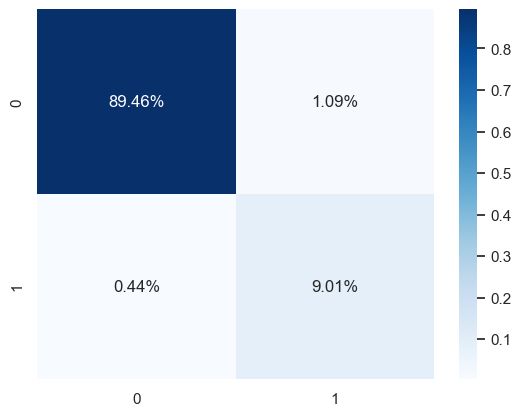

In [119]:
bst.fit(X_train,y_train)
pred = bst.predict(X_test)
cf_matrix = confusion_matrix(y_test, pred)
seaborn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

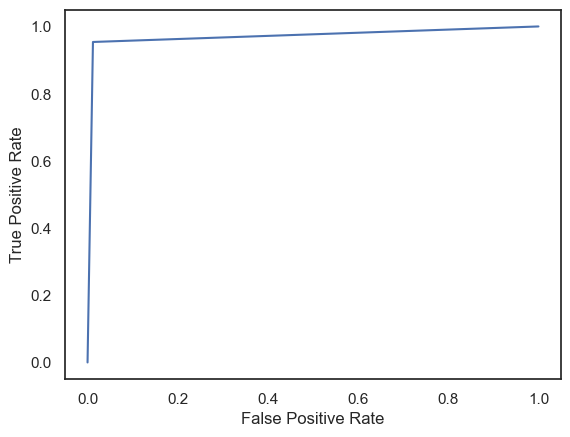

In [121]:
fpr, tpr, _ = metrics.roc_curve(y_test,  pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Explain AI

In [105]:
shap.initjs()

In [106]:
X_sampled = X_train.sample(100, random_state=10)

In [107]:
y_sample = y_train[X_sampled.index]

In [108]:
df_sample = pd.concat([X_sampled, y_sample], axis=1)

In [109]:
df_sample

,ts_delta_fridge,high,low,sphone_signal,ts_delta_motion_light,motion_status,light_status,latitude,longitude,ts_delta_gps,latitude_delta,longitude_delta,temperature,pressure,humidity,ts_delta_weather,temperature_delta,pressure_delta,humidity_delta,label
90463,0.0,0,1,0.0,1.0,1.0,0.0,52.268667,62.672201,3.0,-5.249999,-5.700814,24.017085,1.035,40.001059,1.0,-25.099495,0.0,-38.948562,0
89913,0.0,1,0,0.0,1.0,1.0,0.0,52.268667,62.672201,3.0,-5.249999,-5.700814,24.017085,1.035,40.001059,1.0,-25.099495,0.0,-38.948562,0
81914,0.0,1,0,0.0,1.0,1.0,0.0,52.268667,62.672201,3.0,-5.249999,-5.700814,24.017085,1.035,40.001059,1.0,-25.099495,0.0,-38.948562,0
13323,0.0,1,0,1.0,7.0,0.0,0.0,38.279299,48.705653,3.0,-6.386686,-5.750400,24.017085,1.035,40.001059,1.0,-25.099495,0.0,-38.948562,0
8828,0.0,0,1,0.0,7.0,0.0,0.0,38.279299,48.705653,3.0,-6.386686,-5.750400,24.017085,1.035,40.001059,1.0,-25.099495,0.0,-38.948562,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62128,0.0,1,0,0.0,1.0,1.0,0.0,52.268667,62.672201,3.0,-5.249999,-5.700814,24.017085,1.035,40.001059,1.0,-25.099495,0.0,-38.948562,0
13955,0.0,1,0,0.0,7.0,0.0,0.0,38.279299,48.705653,3.0,-6.386686,-5.750400,24.017085,1.035,40.001059,1.0,-25.099495,0.0,-38.948562,0
21490,0.0,1,0,0.0,1.0,0.0,0.0,52.268667,62.672201,3.0,-5.249999,-5.700814,24.017085,1.035,40.001059,1.0,-25.099495,0.0,-38.948562,0
37857,0.0,0,1,0.0,3.0,0.0,0.0,52.268667,62.672201,3.0,-5.249999,-5.700814,24.017085,1.035,40.001059,1.0,-25.099495,0.0,-38.948562,0


In [110]:
bst.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.67, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=9, max_leaves=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [111]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_sampled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [112]:
X_sampled.index

Int64Index([90463, 89913, 81914, 13323,  8828, 57021, 17813,  7740,  2079,
            87283, 34260, 39073, 93288,  1463, 82896, 53496, 38229, 76226,
              304, 86236, 73746, 74777, 86280, 73319, 45017,   458,  6955,
            51552, 58205,  7708, 80378, 70867, 35196, 50868, 64868, 20849,
            30264, 60507, 24403, 41895, 49352, 86493, 37798, 22247, 15372,
            31283, 66069, 87713, 75924, 23643, 11946, 65341, 40219, 78125,
            62424, 18283, 77644, 14574, 43601, 26532, 62898, 18055, 93831,
            48724, 41429, 11030, 25997, 78686, 81802, 52639, 40658, 21866,
            50737, 64370, 70875, 37312, 58968, 59696, 51079,  4964, 63975,
            72900, 58408, 27236, 66742, 57616, 41547, 27077,  7794, 94330,
            85960,   852, 94292, 90008, 11841, 62128, 13955, 21490, 37857,
            35949],
           dtype='int64')

In [113]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

In [114]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_sampled.iloc[1,:])

In [115]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_sampled.iloc[2,:])

In [116]:
shap.force_plot(explainer.expected_value, shap_values[3,:], X_sampled.iloc[3,:])

In [117]:
shap.force_plot(explainer.expected_value, shap_values[97,:], X_sampled.iloc[97,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


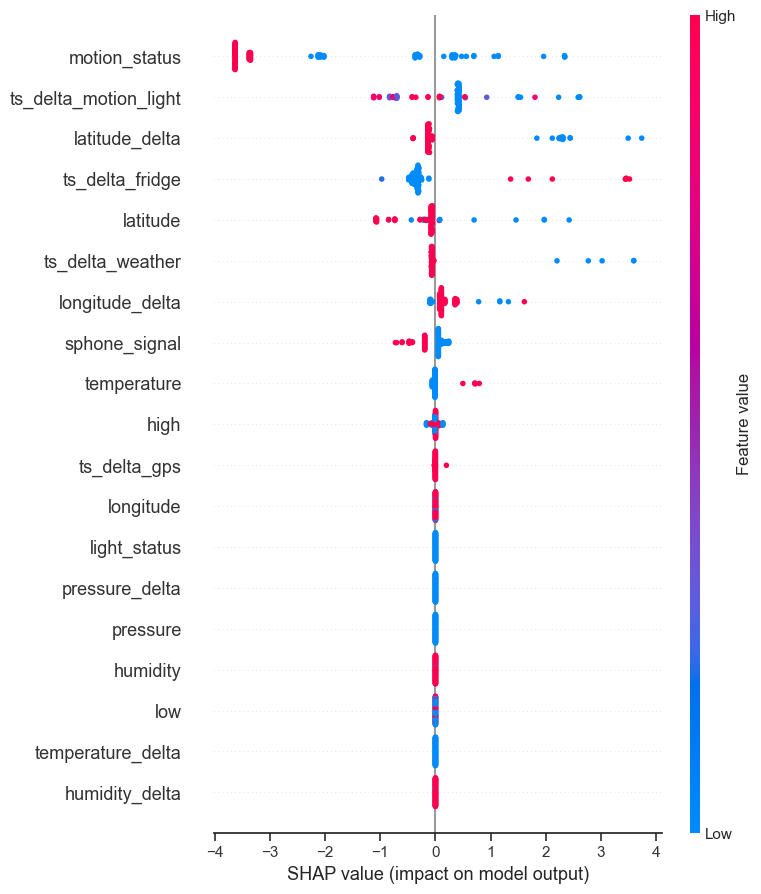

In [118]:
shap.summary_plot(shap_values, X_sampled)